In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def partial_spearman_corr(df, x, y, controls):
    """Compute partial Spearman correlation between x and y given selected control variables."""
    from statsmodels.api import OLS, add_constant
    
    if controls:
        # Regress x and y on control variables
        residual_x = OLS(df[x], add_constant(df[controls])).fit().resid
        residual_y = OLS(df[y], add_constant(df[controls])).fit().resid
        return spearmanr(residual_x, residual_y)[0]
    else:
        return spearmanr(df[x], df[y])[0]

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_causal_graph(adj_matrix, df, ci_test):
    """
    Plots causal graph with edge color based on partial Spearman correlation values.
    Uses only relevant control variables.
    Displays actual correlation values (+/-0.XX) beside the edges.
    Draws arrows for one-way edges and lines for undirected (symmetric) edges.
    """
    nodes = df.columns
    G = nx.DiGraph()
    edge_info = []
    edge_labels = {}

    # Loop through all pairs
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if adj_matrix[i, j] != 0:
                node_i = nodes[i]
                node_j = nodes[j]

                # Identify control variables
                related_vars = [nodes[k] for k in range(len(nodes)) if adj_matrix[k, j] or adj_matrix[k, i]]
                controls = [var for var in related_vars if var not in [node_i, node_j]]

                # Compute partial Spearman correlation
                pcorr = partial_spearman_corr(df, node_i, node_j, controls)

                # Determine edge color and width
                edge_color = '#F2C14E' if pcorr > 0 else '#8e7dbe'
                edge_width = 1 + 2 * abs(pcorr)

                G.add_edge(node_i, node_j, weight=pcorr)
                edge_info.append((node_i, node_j, edge_color, edge_width))
                edge_labels[(node_i, node_j)] = f"{pcorr:+.2f}"

    pos = nx.circular_layout(G)
    label_pos = {n: (p[0] * 1.2, p[1] * 1.2) for n, p in pos.items()}

    plt.figure(figsize=(11, 11), dpi=900)
    node_colors = ['#C9BFE1']  # default purple

    nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        edgecolors='white',
        node_size=500,
        alpha=0.9
    )
    nx.draw_networkx_labels(G, label_pos, font_size=16, font_family="arial", font_color='black')

    # Draw edges: check for symmetric edges
    handled_edges = set()
    for u, v, color, width in edge_info:
        if (v, u) in handled_edges:
            continue  # already handled symmetric pair

        arc_rad = 0.1

        if G.has_edge(v, u):
            
            # symmetric → undirected style
            nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)], width=width, edge_color=color,
            arrowstyle='-', arrowsize=20, connectionstyle=f'arc3,rad={arc_rad}',
            min_source_margin=20, min_target_margin=20
            )
            handled_edges.add((u, v))
        else:
            # one-way → directed arrow
            nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)], width=width, edge_color=color,
            arrowstyle='simple', arrowsize=20, connectionstyle=f'arc3,rad={arc_rad}',
            min_source_margin=20, min_target_margin=20
            )
            handled_edges.add((u, v))

    # Edge labels
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=14,
        font_color='black',
        font_family="arial",
        rotate=True,
        label_pos=0.5,
        bbox=dict(facecolor='none', edgecolor='none', pad=0)
    )

    # Legend
    pos_patch = mpatches.Patch(color='#F2C14E', label='Positive Causality')
    neg_patch = mpatches.Patch(color='#8e7dbe', label='Negative Causality')
    plt.legend(handles=[pos_patch, neg_patch], loc='lower left', fontsize=14, frameon=False)

    plt.gca().margins(x=0.3, y=0.3)
    plt.axis('off')
    plt.show()

In [26]:
import numpy as np
import pandas as pd
from pc_gcastle import PC
from random import shuffle

def run_pc_analysis(df, factor_list, alpha=0.05, shuffle_factors=False, ci_test='spearman'):
    """
    Run PC algorithm for a selected subset of factors.
    
    Parameters:
        df (pd.DataFrame): Original dataframe containing 'factor', 'cbsacode', and 'SSAMI'.
        factor_list (list): List of factor names to include in the analysis.
        alpha (float): Significance level for conditional independence tests.
        shuffle_factors (bool): Whether to shuffle the factor list randomly.
    
    Returns:
        pc (PC object): The trained PC model.
    """
    
    if shuffle_factors:
        shuffle(factor_list)
        print(factor_list)
    
    # Filter and pivot
    df_select = df.loc[df['factor'].isin(factor_list)]
    sami_col = df_select.columns[df_select.columns.str.contains("SAMI", case=False)][0]

    dfp = df_select.pivot(index=["cbsacode",'Year'], columns="factor", values=sami_col).reset_index()
    df_cleaned = dfp.drop(columns=["cbsacode",'Year'])  # Reverse column order as in original code
    df_cleaned = df_cleaned.dropna()
    data_matrix = df_cleaned.to_numpy()

    # Run PC algorithm
    pc = PC(variant='stable', alpha=alpha, ci_test = ci_test)
    pc.learn(data_matrix, columns=df_cleaned.columns)

    result = pc._results
    
    print("Learned skeleton (CPDAG):")
    plot_causal_graph(pc.causal_matrix, df_cleaned,ci_test)
    
    return result

In [43]:
my_factors = ['Depression',
    # health
    # 'excessive_drinking',
    # 'adult_obesity',
    # 'sti', 
    'Unhealthy Lifestyle',
    # 'smo_obe', 
    # 'smo_dia', 
    # 'obe_dia', 
    'Physical Inactivity', 

    # education
    # 'some_college',

    # economic
    # 'unemployment', #no direct link with depression
    'GDP', 
    # 'median_household_income', #add this the no time activity become result

    # health source
    'Mental Health Providers', 

    # social association
    # 'children_single_parent',

    # enviroment
    # 'driving_alone_to_work', 
    'Park Area',
    # 'Weighted_RESP', 
    # 'noise70n', 
    # 'noise80n', 
    'Noise', 
    
]

# SASAMI

In [8]:
df = pd.read_csv('../00_data/03_analysis_data/20250716_sasami.csv')

In [9]:
df 

,cbsacode,Year,factor,baseline_moran_value,baseline_moran_p,final_moran_value,final_moran_p,selected_k,SSAMI,ln_pop_beta,ln_pop_p,ln_pop_CI_lower,ln_pop_CI_upper,ln_area_beta,ln_area_p,ln_area_CI_lower,ln_area_CI_upper
0,10100,2022,adult_smoking,0.530344,0.005,0.053144,0.05,113,-0.055477,0.910176,0.0,0.900044,0.920309,0.055902,4.624213e-11,0.039475,0.072328
1,10140,2022,adult_smoking,0.530344,0.005,0.053144,0.05,113,0.080598,0.910176,0.0,0.900044,0.920309,0.055902,4.624213e-11,0.039475,0.072328
2,10180,2022,adult_smoking,0.530344,0.005,0.053144,0.05,113,0.038265,0.910176,0.0,0.900044,0.920309,0.055902,4.624213e-11,0.039475,0.072328
3,10220,2022,adult_smoking,0.530344,0.005,0.053144,0.05,113,0.080998,0.910176,0.0,0.900044,0.920309,0.055902,4.624213e-11,0.039475,0.072328
4,10300,2022,adult_smoking,0.530344,0.005,0.053144,0.05,113,-0.055591,0.910176,0.0,0.900044,0.920309,0.055902,4.624213e-11,0.039475,0.072328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19954,49660,2022,depressed,0.528420,0.005,0.073271,0.01,127,-0.037998,0.980991,0.0,0.973085,0.988896,0.015956,1.460580e-02,0.003159,0.028752
19955,49700,2022,depressed,0.528420,0.005,0.073271,0.01,127,0.025670,0.980991,0.0,0.973085,0.988896,0.015956,1.460580e-02,0.003159,0.028752
19956,49740,2022,depressed,0.528420,0.005,0.073271,0.01,127,-0.137124,0.980991,0.0,0.973085,0.988896,0.015956,1.460580e-02,0.003159,0.028752
19957,49780,2022,depressed,0.528420,0.005,0.073271,0.01,127,-0.025364,0.980991,0.0,0.973085,0.988896,0.015956,1.460580e-02,0.003159,0.028752


In [38]:
df

,cbsacode,Year,factor,baseline_moran_value,baseline_moran_p,final_moran_value,final_moran_p,selected_k,SSAMI,ln_pop_beta,ln_pop_p,ln_pop_CI_lower,ln_pop_CI_upper,ln_area_beta,ln_area_p,ln_area_CI_lower,ln_area_CI_upper
0,10100,2022,adult_smoking,0.530344,0.005,0.053144,0.05,113,-0.055477,0.910176,0.0,0.900044,0.920309,0.055902,4.624213e-11,0.039475,0.072328
1,10140,2022,adult_smoking,0.530344,0.005,0.053144,0.05,113,0.080598,0.910176,0.0,0.900044,0.920309,0.055902,4.624213e-11,0.039475,0.072328
2,10180,2022,adult_smoking,0.530344,0.005,0.053144,0.05,113,0.038265,0.910176,0.0,0.900044,0.920309,0.055902,4.624213e-11,0.039475,0.072328
3,10220,2022,adult_smoking,0.530344,0.005,0.053144,0.05,113,0.080998,0.910176,0.0,0.900044,0.920309,0.055902,4.624213e-11,0.039475,0.072328
4,10300,2022,adult_smoking,0.530344,0.005,0.053144,0.05,113,-0.055591,0.910176,0.0,0.900044,0.920309,0.055902,4.624213e-11,0.039475,0.072328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19954,49660,2022,DEP,0.528420,0.005,0.073271,0.01,127,-0.037998,0.980991,0.0,0.973085,0.988896,0.015956,1.460580e-02,0.003159,0.028752
19955,49700,2022,DEP,0.528420,0.005,0.073271,0.01,127,0.025670,0.980991,0.0,0.973085,0.988896,0.015956,1.460580e-02,0.003159,0.028752
19956,49740,2022,DEP,0.528420,0.005,0.073271,0.01,127,-0.137124,0.980991,0.0,0.973085,0.988896,0.015956,1.460580e-02,0.003159,0.028752
19957,49780,2022,DEP,0.528420,0.005,0.073271,0.01,127,-0.025364,0.980991,0.0,0.973085,0.988896,0.015956,1.460580e-02,0.003159,0.028752


In [ ]:
df = pd.read_csv('../00_data/03_analysis_data/20250716_sasami.csv')
df.loc[df['factor'] == 'Park_Area_Acres', 'factor'] = 'PARK'
df.loc[df['factor'] == 'noise90n', 'factor'] = 'NOI'
df.loc[df['factor'] == 'no_time_activity', 'factor'] = 'PI'
df.loc[df['factor'] == 'smo_obe_dia', 'factor'] = 'UNH'
df.loc[df['factor'] == 'depressed', 'factor'] = 'DEP'
df.loc[df['factor'] == 'gdp', 'factor'] = 'GDP'
df.loc[df['factor'] == 'mental_health_providers', 'factor'] = 'MHP'

In [30]:
my_factors = ['GDP','PARK','PI','DEP','MHP','adult_smoking','adult_obesity']

In [35]:
df_select = df.loc[df['factor'].isin(my_factors)]
dfp = df_select.pivot(index=["cbsacode",'Year'], columns="factor", values="SSAMI").reset_index()
df_cleaned = dfp.drop(columns=["cbsacode",'Year'])  # Reverse column order as in original code
df_cleaned = df_cleaned.dropna()

In [36]:
df_cleaned

factor,DEP,GDP,MHP,PARK,adult_obesity,adult_smoking
0,-0.014459,0.402133,-0.260852,-0.027418,-0.025071,-0.055477
1,0.039069,-0.218720,-0.304564,1.368567,0.124160,0.080598
2,0.053466,-0.339701,-0.042121,0.298309,-0.037834,0.038265
3,0.147964,0.173446,1.541302,-1.921857,0.008090,0.080998
4,-0.024906,-0.434104,0.278625,-0.716250,0.037204,-0.055591
...,...,...,...,...,...,...
863,-0.037998,-0.311314,0.335782,-0.815190,0.009282,0.014118
864,0.025670,-0.168017,-0.221567,-2.098415,-0.008110,0.058372
865,-0.137124,-0.108984,-0.934298,-3.928242,0.207021,0.065513
866,-0.025364,0.159983,-0.436102,2.950623,0.031467,0.039092


In [31]:
pc_result= run_pc_analysis(df, factor_list=my_factors, alpha=0.05, shuffle_factors=True,ci_test='mutual_info')

['DEP', 'PI', 'GDP', 'adult_smoking', 'adult_obesity', 'PARK', 'MHP']
Learned skeleton (CPDAG):


In [15]:
pc_result= run_pc_analysis(df, factor_list=my_factors, alpha=0.05, shuffle_factors=True,ci_test='spearman')

Learned skeleton (CPDAG):


In [16]:
pc_result= run_pc_analysis(df, factor_list=my_factors, alpha=0.01, shuffle_factors=True,ci_test='spearman')

Learned skeleton (CPDAG):


In [47]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ---- 数据准备 ----

# 假设你已有 DataFrame `df`，并包含 'cbsacode'、'Year'、'factor'、'SSAMI'
# 和一个包含你要分析的 factor 名称列表：my_factors

# 透视表：行为 (cbsacode, Year)，列为 factor，值为 SSAMI
dfp = df.pivot(index=["cbsacode", "Year"], columns="factor", values="SSAMI").reset_index()
df_cleaned = dfp[my_factors]

# 因子列表（去掉 index 列）
factor_list = df_cleaned.columns.drop('cbsacode', errors='ignore')

# ---- 相关性和 p 值计算 ----

# 初始化空矩阵
spearman_corr = pd.DataFrame(index=factor_list, columns=factor_list, dtype=float)
p_values = pd.DataFrame(index=factor_list, columns=factor_list, dtype=float)

# 两两组合计算 Spearman 相关性
for f1, f2 in itertools.combinations(factor_list, 2):
    corr, p_value = spearmanr(df_cleaned[f1], df_cleaned[f2])
    spearman_corr.loc[f1, f2] = spearman_corr.loc[f2, f1] = corr
    p_values.loc[f1, f2] = p_values.loc[f2, f1] = p_value

# 对角线赋值为 1 和 p=1
np.fill_diagonal(spearman_corr.values, 1)
np.fill_diagonal(p_values.values, 1)

# ---- 注释矩阵和遮罩 ----

# 标记显著性：p ≤ 0.05 显示 'X'
annot_matrix = np.where(p_values.to_numpy() <= 0.05, 'X', '')

# 遮罩上三角
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))

# ---- 自定义颜色矩阵 ----

color_matrix = np.full(spearman_corr.shape, '', dtype=object)

for i in range(spearman_corr.shape[0]):
    for j in range(spearman_corr.shape[1]):
        if mask[i, j]:
            color_matrix[i, j] = '#FFFFFF00'  # 上三角透明
            continue

        pcorr = spearman_corr.iloc[i, j]
        p = p_values.iloc[i, j]

        if pd.isna(pcorr) or pd.isna(p):
            color_matrix[i, j] = '#FFFFFF00'
        elif p == 0:
            color_matrix[i, j] = '#D3D3D3'  # 浅灰
        else:
            # 透明度与相关系数强度相关（非线性缩放）
            alpha = min(1.0, abs(pcorr)**0.7 * 1.5)
            hex_color = '#F2C14E' if pcorr > 0 else '#5FAD56'
            rgb = tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))
            rgba_tuple = (rgb[0]/255, rgb[1]/255, rgb[2]/255, alpha)
            color_matrix[i, j] = rgba_tuple

# ---- 绘图 ----

fig, ax = plt.subplots(figsize=(10, 8))

# 白底 + 注释层
sns.heatmap(np.zeros_like(spearman_corr, dtype=float),
            annot=annot_matrix,
            fmt="",
            mask=mask,
            cmap="Greys",
            cbar=False,
            linewidths=0.5,
            ax=ax)

# 叠加矩阵色块
for i in range(spearman_corr.shape[0]):
    for j in range(spearman_corr.shape[1]):
        if mask[i, j]:
            continue
        ax.add_patch(plt.Rectangle((j, i), 1, 1,
                                   facecolor=color_matrix[i, j],
                                   edgecolor='white', lw=0.5))

from matplotlib import font_manager

# 设置字体
font_prop = font_manager.FontProperties(family='Arial',size=18)

# 标题
ax.set_title("Spearman Correlation Heatmap (SASAMI)", fontproperties=font_prop)

# 坐标轴刻度位置
ax.set_xticks(np.arange(len(spearman_corr.columns))+0.5)
ax.set_yticks(np.arange(len(spearman_corr.index)) + 0.5)

# 坐标轴标签文字及字体
ax.set_xticklabels(spearman_corr.columns, rotation=90, ha="center", fontproperties=font_prop)
ax.set_yticklabels(spearman_corr.index, rotation=0, fontproperties=font_prop)

# ---- 图例（可选）----

from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize

# 创建颜色映射：负相关 -> 灰色 -> 正相关
cmap = LinearSegmentedColormap.from_list("corrmap", ['#5FAD56', '#D3D3D3', '#F2C14E'])
norm = Normalize(vmin=-1, vmax=1)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# 添加横向 colorbar 放在图底部
cbar = plt.colorbar(sm, ax=ax, fraction=0.05, pad=0.15)
cbar.set_label("Spearman Correlation", fontsize=12)
cbar.outline.set_visible(False)

plt.tight_layout()
plt.show()


KeyError: "['Depression', 'Unhealthy Lifestyle', 'Physical Inactivity', 'Mental Health Providers', 'Park Area', 'Noise'] not in index"

In [17]:
my_factors

['PI', 'DEP', 'MHP', 'GDP', 'PARK', 'NOI']

In [18]:
pc_result

[(0, 1, [], -0.21704358854180203, 1.1653121393559435e-10),
 (0, 2, [], 0.16313896588487733, 1.4509430632413974e-06),
 (0, 3, [], -0.14918786782200977, 1.0776777813061751e-05),
 (0, 4, [], 0.007462057631534689, 0.8267301618679724),
 (1, 2, [], -0.017235245821081935, 0.6131226448990034),
 (1, 3, [], 0.15901682395953848, 2.6719916220143203e-06),
 (1, 4, [], 0.03242548640404687, 0.3413868609905317),
 (2, 3, [], -0.06816646786616111, 0.04529081710392473),
 (2, 4, [], -0.007039121131493017, 0.8364080754425184),
 (3, 4, [], 0.011895282767207447, 0.7271253951354963),
 (0, 1, [2], -0.21129603590895743, 3.630684267592107e-10),
 (0, 1, [3], -0.19610863319947533, 6.277027326067793e-09),
 (0, 2, [1], 0.15902830614501173, 2.6675074446278956e-06),
 (0, 2, [3], 0.15154576728182803, 7.773270976669441e-06),
 (0, 3, [1], -0.12411786943212956, 0.00025713129735475504),
 (0, 3, [2], -0.14262817927713092, 2.6060560521759807e-05),
 (1, 3, [0], 0.12882534143352042, 0.00014774935303523936),
 (0, 1, [2, 3], -0.1

In [19]:
records = []
for (x_idx, y_idx,cond_indices,corr, p_val ) in pc_result:
    # Convert x_idx and y_idx to factor names:
    x_name = my_factors[x_idx]
    y_name = my_factors[y_idx]
    # Convert conditioning indices (if any) to factor names:
    cond_names = [my_factors[z] for z in cond_indices]

    records.append({
        "X": x_name,
        "Y": y_name,
        "Z":  cond_names,
        "Spearman":corr,
        "p value": p_val
    })

df = pd.DataFrame(records)


In [20]:
df.to_csv("../00_data/04_output/sasami_result.csv",index=False)

In [21]:
import pandas as pd
import ast

# Load your CSV
df = pd.read_csv("../00_data/04_output/sasami_result.csv")


# Clean Z column
def clean_z(z):
    try:
        items = ast.literal_eval(z)
        if isinstance(items, list) and len(items) == 0:
            return '-'
        elif isinstance(items, list):
            return ', '.join(str(i) for i in items)
    except:
        return z
    return z

# Apply formatting
df['Z'] = df['Z'].apply(clean_z)
df['Spearman'] = df['Spearman'].astype(float).apply(lambda x: f"{x:.2f}")
df['p value'] = df['p value'].astype(float).apply(lambda x: r"\textless{} 0.001" if x < 0.001 else f"{x:.3f}")

# Split side by side
half = len(df) // 2 + len(df) % 2
df1 = df.iloc[:half].reset_index(drop=True)
df2 = df.iloc[half:].reset_index(drop=True)
combined = pd.concat([df1, df2], axis=1)
combined.columns = ['X', 'Y', 'Z', 'Spearman', 'p value', 'X', 'Y', 'Z', 'Spearman', 'p value']

# Export to LaTeX
latex_code = combined.to_latex(
    index=False,
    column_format="|l|l|l|r|r||l|l|l|r|r|",
    escape=False
)

In [22]:
with open("sasami_table_final.tex", "w") as f:
    f.write(latex_code)

# Density

In [ ]:
df2 = pd.read_csv('../00_data/03_analysis_data/sami_result_0403.csv')

ci_test is now: spearman
Learned skeleton (CPDAG):


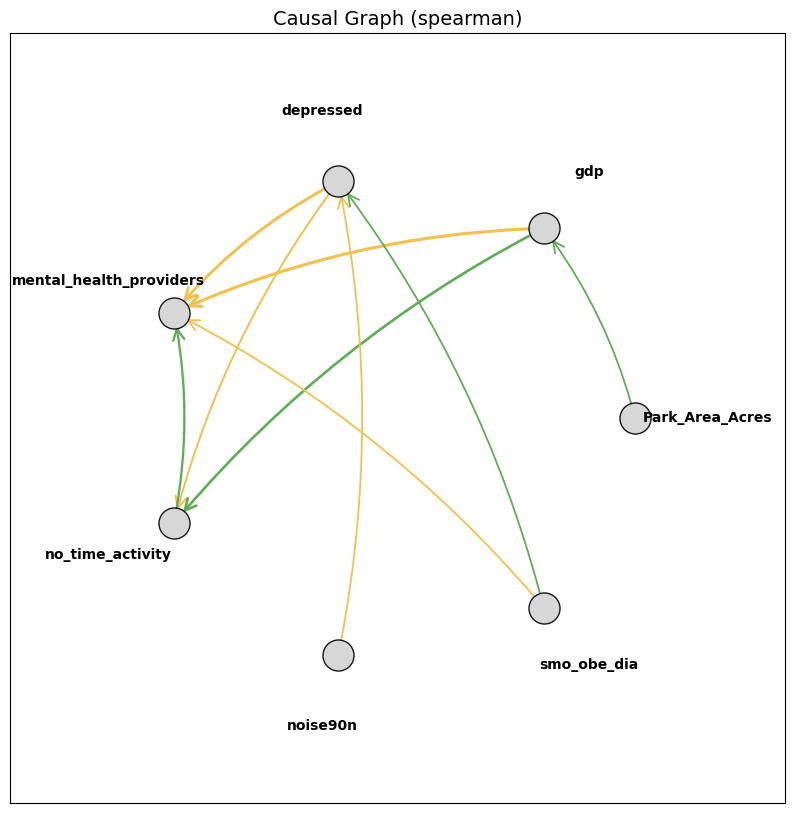

In [ ]:
pc_result = run_pc_analysis(df2, factor_list=my_factors, alpha=0.05, shuffle_factors=True,ci_test='spearman')

ci_test is now: mutual_info
Learned skeleton (CPDAG):


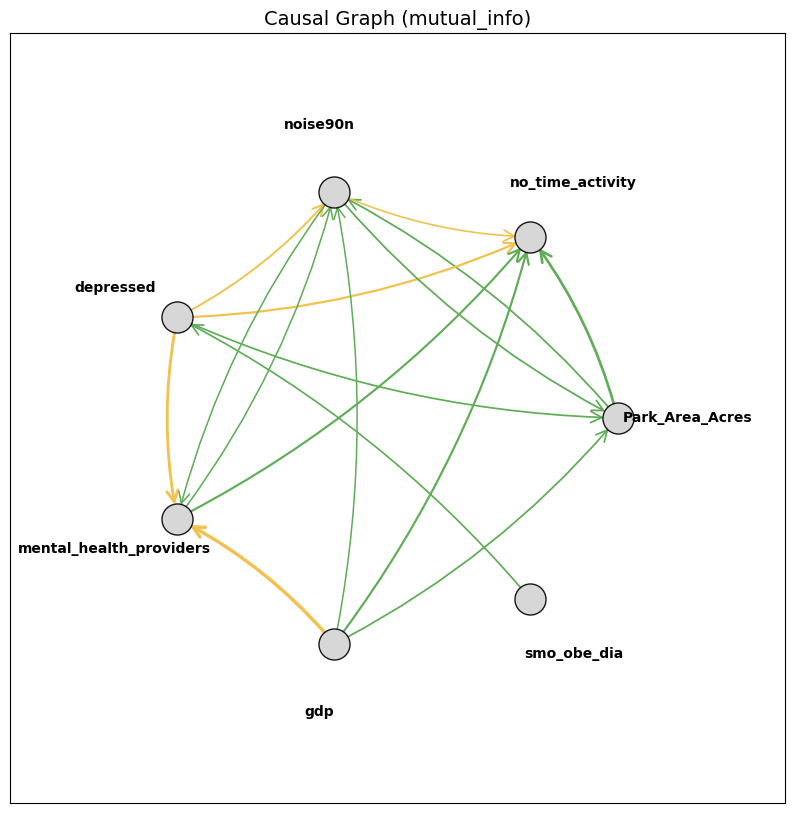

In [ ]:
pc_result = run_pc_analysis(df2, factor_list=my_factors, alpha=0.01, shuffle_factors=True,ci_test='mutual_info')

---

In [ ]:
df3 = pd.read_csv('../00_data/03_analysis_data/all_factor_72_12.csv')

In [ ]:
df

,cbsacode,Year,factor,baseline_moran_value,baseline_moran_p,final_moran_value,final_moran_p,selected_k,SSAMI,ln_pop_beta,ln_pop_p,ln_pop_CI_lower,ln_pop_CI_upper,ln_area_beta,ln_area_p,ln_area_CI_lower,ln_area_CI_upper
0,10740,2011,excessive_drinking,0.298481,0.001,0.026173,0.126,132,-0.313637,1.005161,0.0,0.988715,1.021607,-0.004096,0.813785,-0.038220,0.030028
1,11260,2011,excessive_drinking,0.298481,0.001,0.026173,0.126,132,-0.025590,1.005161,0.0,0.988715,1.021607,-0.004096,0.813785,-0.038220,0.030028
2,12060,2011,excessive_drinking,0.298481,0.001,0.026173,0.126,132,-0.057418,1.005161,0.0,0.988715,1.021607,-0.004096,0.813785,-0.038220,0.030028
3,12260,2011,excessive_drinking,0.298481,0.001,0.026173,0.126,132,-0.041601,1.005161,0.0,0.988715,1.021607,-0.004096,0.813785,-0.038220,0.030028
4,12420,2011,excessive_drinking,0.298481,0.001,0.026173,0.126,132,0.254033,1.005161,0.0,0.988715,1.021607,-0.004096,0.813785,-0.038220,0.030028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17275,45820,2022,depressed,0.289262,0.001,0.018403,0.194,72,-0.006041,0.933195,0.0,0.923049,0.943340,-0.032342,0.003506,-0.054023,-0.010662
17276,46140,2022,depressed,0.289262,0.001,0.018403,0.194,72,0.371638,0.933195,0.0,0.923049,0.943340,-0.032342,0.003506,-0.054023,-0.010662
17277,47260,2022,depressed,0.289262,0.001,0.018403,0.194,72,0.113171,0.933195,0.0,0.923049,0.943340,-0.032342,0.003506,-0.054023,-0.010662
17278,48620,2022,depressed,0.289262,0.001,0.018403,0.194,72,0.000698,0.933195,0.0,0.923049,0.943340,-0.032342,0.003506,-0.054023,-0.010662


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def scaling(X, y, ci_vars=None):
    """
    Perform OLS regression of y on X (with intercept). Returns coefficients, 
    confidence intervals, R-squared, and number of observations.

    Parameters:
    - X: DataFrame or Series of predictor(s)
    - y: Series of response variable
    - ci_vars: List of variable names (str) for which to extract 95% CI 
               If None, return CI for all predictors

    Returns:
    - betas: Dictionary of coefficients {var_name: beta}
    - cis: Dictionary of 95% CIs {var_name: (lower, upper)}
    - r_squared: R-squared of the regression
    - n: Number of observations
    """
    if isinstance(X, pd.Series):
        X = X.to_frame()

    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    betas = model.params.to_dict()
    conf_int = model.conf_int(alpha=0.05)

    if ci_vars is None:
        ci_vars = X.columns.tolist()
    
    cis = {var: tuple(conf_int.loc[var]) for var in ci_vars if var in conf_int.index}

    return betas, cis, model.rsquared, len(y)

In [ ]:
df

,Pair,p_value,Conditional_Factors
0,"Depression, Unhealthy Lifestyle",0.00,
1,"Depression, Physical Inactivity",0.00,
2,"Depression, GDP",0.00,
3,"Depression, Mental Health Providers",0.72,
4,"Depression, Park Area",0.00,
...,...,...,...
74,"Depression, GDP",0.00,"Unhealthy Lifestyle, Physical Inactivity, Park..."
75,"Depression, Park Area",0.00,"Unhealthy Lifestyle, Physical Inactivity, GDP"
76,"Unhealthy Lifestyle, Physical Inactivity",0.00,"Depression, Mental Health Providers, Park Area"
77,"Unhealthy Lifestyle, Mental Health Providers",0.00,"Depression, Physical Inactivity, Park Area"


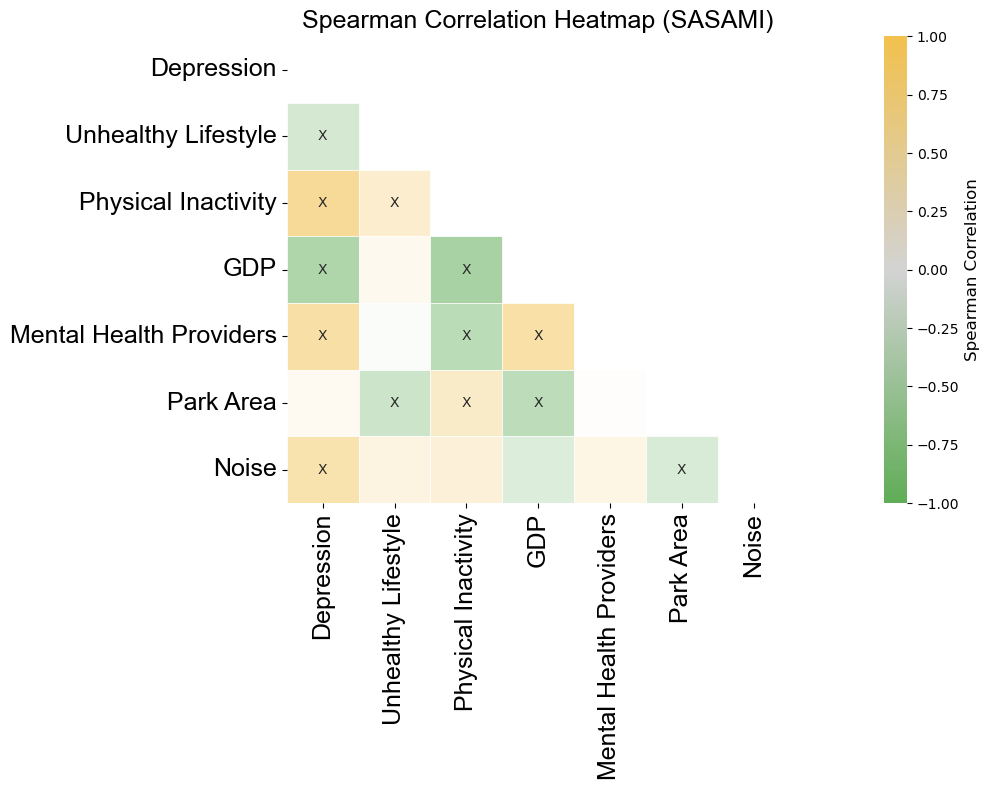

In [ ]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ---- 数据准备 ----

# 假设你已有 DataFrame `df`，并包含 'cbsacode'、'Year'、'factor'、'SSAMI'
# 和一个包含你要分析的 factor 名称列表：my_factors

# 透视表：行为 (cbsacode, Year)，列为 factor，值为 SSAMI
dfp = df.pivot(index=["cbsacode", "Year"], columns="factor", values="SSAMI").reset_index()
df_cleaned = dfp[my_factors]

# 因子列表（去掉 index 列）
factor_list = df_cleaned.columns.drop('cbsacode', errors='ignore')

# ---- 相关性和 p 值计算 ----

# 初始化空矩阵
spearman_corr = pd.DataFrame(index=factor_list, columns=factor_list, dtype=float)
p_values = pd.DataFrame(index=factor_list, columns=factor_list, dtype=float)

# 两两组合计算 Spearman 相关性
for f1, f2 in itertools.combinations(factor_list, 2):
    corr, p_value = spearmanr(df_cleaned[f1], df_cleaned[f2])
    spearman_corr.loc[f1, f2] = spearman_corr.loc[f2, f1] = corr
    p_values.loc[f1, f2] = p_values.loc[f2, f1] = p_value

# 对角线赋值为 1 和 p=1
np.fill_diagonal(spearman_corr.values, 1)
np.fill_diagonal(p_values.values, 1)

# ---- 注释矩阵和遮罩 ----

# 标记显著性：p ≤ 0.05 显示 'X'
annot_matrix = np.where(p_values.to_numpy() <= 0.05, 'X', '')

# 遮罩上三角
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))

# ---- 自定义颜色矩阵 ----

color_matrix = np.full(spearman_corr.shape, '', dtype=object)

for i in range(spearman_corr.shape[0]):
    for j in range(spearman_corr.shape[1]):
        if mask[i, j]:
            color_matrix[i, j] = '#FFFFFF00'  # 上三角透明
            continue

        pcorr = spearman_corr.iloc[i, j]
        p = p_values.iloc[i, j]

        if pd.isna(pcorr) or pd.isna(p):
            color_matrix[i, j] = '#FFFFFF00'
        elif p == 0:
            color_matrix[i, j] = '#D3D3D3'  # 浅灰
        else:
            # 透明度与相关系数强度相关（非线性缩放）
            alpha = min(1.0, abs(pcorr)**0.7 * 1.5)
            hex_color = '#F2C14E' if pcorr > 0 else '#5FAD56'
            rgb = tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))
            rgba_tuple = (rgb[0]/255, rgb[1]/255, rgb[2]/255, alpha)
            color_matrix[i, j] = rgba_tuple

# ---- 绘图 ----

fig, ax = plt.subplots(figsize=(10, 8))

# 白底 + 注释层
sns.heatmap(np.zeros_like(spearman_corr, dtype=float),
            annot=annot_matrix,
            fmt="",
            mask=mask,
            cmap="Greys",
            cbar=False,
            linewidths=0.5,
            ax=ax)

# 叠加矩阵色块
for i in range(spearman_corr.shape[0]):
    for j in range(spearman_corr.shape[1]):
        if mask[i, j]:
            continue
        ax.add_patch(plt.Rectangle((j, i), 1, 1,
                                   facecolor=color_matrix[i, j],
                                   edgecolor='white', lw=0.5))

from matplotlib import font_manager

# 设置字体
font_prop = font_manager.FontProperties(family='Arial',size=18)

# 标题
ax.set_title("Spearman Correlation Heatmap (SASAMI)", fontproperties=font_prop)

# 坐标轴刻度位置
ax.set_xticks(np.arange(len(spearman_corr.columns))+0.5)
ax.set_yticks(np.arange(len(spearman_corr.index)) + 0.5)

# 坐标轴标签文字及字体
ax.set_xticklabels(spearman_corr.columns, rotation=90, ha="center", fontproperties=font_prop)
ax.set_yticklabels(spearman_corr.index, rotation=0, fontproperties=font_prop)

# ---- 图例（可选）----

from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize

# 创建颜色映射：负相关 -> 灰色 -> 正相关
cmap = LinearSegmentedColormap.from_list("corrmap", ['#5FAD56', '#D3D3D3', '#F2C14E'])
norm = Normalize(vmin=-1, vmax=1)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# 添加横向 colorbar 放在图底部
cbar = plt.colorbar(sm, ax=ax, fraction=0.05, pad=0.15)
cbar.set_label("Spearman Correlation", fontsize=12)
cbar.outline.set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
df_cleaned

factor,unemployment,suicide,some_college,social_associations,single_parent,physical_access,noise70n,mental_health_providers,median_household_income,health_pca,driving_alone,depressed,adult_sti,adult_smoking,adult_obesity,adult_excessive_drinking,adult_diabetes_prevalence,Weighted_RESP,Park_Area_Acres,cbsacode
0,0.259455,-0.018385,-0.086131,-8.647446e-07,0.289256,-0.004021,0.868742,0.409572,0.018044,5.714567,-0.038890,0.103655,0.315699,0.120002,-0.126914,-0.008491,0.040265,-0.015597,-0.744463,10740
1,0.190902,-0.030856,0.092735,-6.706471e-07,-0.136276,0.080169,-3.731388,0.414006,-0.657471,12.126948,-0.058087,-0.202691,-0.484830,-0.020074,0.030962,0.217990,-0.118175,-0.016470,3.331501,11260
2,0.022540,-0.003900,0.011432,9.303954e-07,0.020388,0.454803,0.766646,-0.110429,0.521230,-1.312746,0.039741,-0.118223,0.818965,0.428573,0.495718,0.439306,0.476741,-0.000703,-0.151473,12060
3,0.128995,-0.052560,-0.074841,-2.261422e-07,0.198081,-0.182118,-0.175962,-0.063261,0.260436,-4.319615,-0.053592,-0.094521,0.160658,-0.074845,-0.017904,-0.053782,0.104967,-0.036916,-0.611291,12260
4,-0.074798,0.064764,0.293661,-4.200232e-07,-0.344886,-0.090087,-0.375127,-0.015885,-0.022458,2.396649,0.005229,-0.056843,0.065412,-0.166990,-0.364877,0.124824,-0.507320,-0.061818,1.326678,12420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.171629,0.014015,-0.110264,9.330374e-07,-0.093345,0.062393,0.023538,0.177713,0.443269,-2.777601,-0.064547,0.020999,0.230177,0.071739,0.161539,0.053054,0.169483,0.007104,-0.515335,45820
68,0.001504,0.095280,-0.105864,-2.103814e-07,0.047760,-0.079996,0.051525,0.618630,0.047670,-1.079003,-0.025657,0.210277,0.047576,0.041423,-0.008000,-0.081407,0.047613,0.014528,-0.410308,46140
69,-0.107209,-0.031655,0.114490,-5.443947e-07,0.167208,-0.027494,-1.989421,-0.273355,0.626579,-4.901460,0.102905,-0.038528,0.928063,0.010265,-0.014229,0.073670,-0.093459,-0.011947,0.790423,47260
70,0.110604,0.101990,-0.017608,-2.297330e-07,0.057370,0.006152,-0.368799,-0.023090,-0.122775,NaN,0.000467,0.008298,-0.387958,0.051909,0.036500,0.045092,0.016698,0.029388,-0.237277,48620


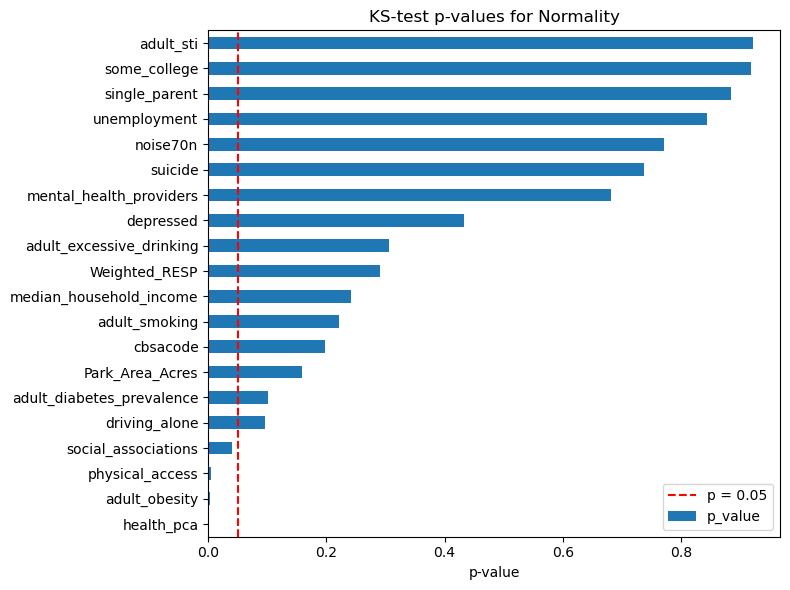

In [ ]:
from scipy.stats import kstest, zscore
import pandas as pd

# Assume your data is in a dataframe called df_factors (like in the image)
# Example: df_factors = df.drop(columns="factor") if "factor" is just index

ks_results = {}

# Loop through each column and perform KS test after z-score normalization
for col in df_cleaned.columns:
    data = df_cleaned[col].dropna()  # Drop NaNs if any
    standardized_data = zscore(data)  # Standardize to mean 0, std 1
    stat, p_value = kstest(standardized_data, 'norm')  # Test against N(0,1)
    ks_results[col] = {"KS_statistic": stat, "p_value": p_value}

# Convert to DataFrame for display
ks_df = pd.DataFrame(ks_results).T
ks_df["normal"] = ks_df["p_value"] > 0.05  # True if fails to reject normality

import matplotlib.pyplot as plt

# Optional: plot the p-values
ks_df["p_value"].sort_values().plot(kind="barh", figsize=(8,6))
plt.axvline(x=0.05, color='red', linestyle='--', label='p = 0.05')
plt.title("KS-test p-values for Normality")
plt.xlabel("p-value")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_cleaned= df_cleaned.drop

factor,unemployment,suicide,some_college,social_associations,single_parent,physical_access,noise70n,mental_health_providers,median_household_income,health_pca,driving_alone,depressed,adult_sti,adult_smoking,adult_obesity,adult_excessive_drinking,adult_diabetes_prevalence,Weighted_RESP,Park_Area_Acres,cbsacode
0,0.259455,-0.018385,-0.086131,-8.647446e-07,0.289256,-0.004021,0.868742,0.409572,0.018044,5.714567,-0.038890,0.103655,0.315699,0.120002,-0.126914,-0.008491,0.040265,-0.015597,-0.744463,10740
1,0.190902,-0.030856,0.092735,-6.706471e-07,-0.136276,0.080169,-3.731388,0.414006,-0.657471,12.126948,-0.058087,-0.202691,-0.484830,-0.020074,0.030962,0.217990,-0.118175,-0.016470,3.331501,11260
2,0.022540,-0.003900,0.011432,9.303954e-07,0.020388,0.454803,0.766646,-0.110429,0.521230,-1.312746,0.039741,-0.118223,0.818965,0.428573,0.495718,0.439306,0.476741,-0.000703,-0.151473,12060
3,0.128995,-0.052560,-0.074841,-2.261422e-07,0.198081,-0.182118,-0.175962,-0.063261,0.260436,-4.319615,-0.053592,-0.094521,0.160658,-0.074845,-0.017904,-0.053782,0.104967,-0.036916,-0.611291,12260
4,-0.074798,0.064764,0.293661,-4.200232e-07,-0.344886,-0.090087,-0.375127,-0.015885,-0.022458,2.396649,0.005229,-0.056843,0.065412,-0.166990,-0.364877,0.124824,-0.507320,-0.061818,1.326678,12420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.171629,0.014015,-0.110264,9.330374e-07,-0.093345,0.062393,0.023538,0.177713,0.443269,-2.777601,-0.064547,0.020999,0.230177,0.071739,0.161539,0.053054,0.169483,0.007104,-0.515335,45820
68,0.001504,0.095280,-0.105864,-2.103814e-07,0.047760,-0.079996,0.051525,0.618630,0.047670,-1.079003,-0.025657,0.210277,0.047576,0.041423,-0.008000,-0.081407,0.047613,0.014528,-0.410308,46140
69,-0.107209,-0.031655,0.114490,-5.443947e-07,0.167208,-0.027494,-1.989421,-0.273355,0.626579,-4.901460,0.102905,-0.038528,0.928063,0.010265,-0.014229,0.073670,-0.093459,-0.011947,0.790423,47260
70,0.110604,0.101990,-0.017608,-2.297330e-07,0.057370,0.006152,-0.368799,-0.023090,-0.122775,NaN,0.000467,0.008298,-0.387958,0.051909,0.036500,0.045092,0.016698,0.029388,-0.237277,48620
